In [1]:
import numpy as n
from matplotlib import pyplot as plt
import os
import numpy.lib.recfunctions as rfn

In [218]:
def dot(a, b):
    return n.sum(a * b, axis=-1)

def mag(a):
    return n.sqrt(n.sum(a*a, axis=-1))

def get_angle(a, b):
    cosab = dot(a, b) / (mag(a) * mag(b)) # cosine of angle between vectors
    angle = n.arccos(cosab) # what you currently have (absolute angle)

    b_t = b[:,[1,0]] * [1, -1] # perpendicular of b

    is_cc = dot(a, b_t) < 0

    # invert the angles for counter-clockwise rotations
    angle[is_cc] = 2*n.pi - angle[is_cc]
    return 360 - n.rad2deg(angle)

### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [3]:
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'

dlc_path = os.path.join(data_root, dlc_dir)
ann_path = os.path.join(data_root, ann_dir)

In [448]:
all_data = {}
print("Loading files: ")
for f_name in os.listdir(dlc_path):
    if f_name[-3:] != 'npy':
        continue
        
    dlc_file=os.path.join(dlc_path, f_name)
    ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
    print("\t" + f_name + "\n\tAnnotated_" + f_name)
    data_dlc = n.load(dlc_file)
    data_ann = n.load(ann_file)
    labels = data_dlc[0]
    dtype = [('t', n.int), ('ann', 'U30')]
    i = 0
    for label in data_dlc[0]:
        i += 1
        coord = 'x' if i % 2 == 0 else 'y'
        dtype += [(label + '_' + coord , n.float32 )]

    data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
    data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
    for i in range(data_concat.shape[1]):
        data[dtype[i][0]] = data_concat[:, i]
    all_data[f_name[:-4]] = data

Loading files: 
	Female1.npy
	Annotated_Female1.npy
	Female2.npy
	Annotated_Female2.npy
	Female3.npy
	Annotated_Female3.npy
	Female4.npy
	Annotated_Female4.npy
	Male1.npy
	Annotated_Male1.npy
	Male2.npy
	Annotated_Male2.npy
	Male3.npy
	Annotated_Male3.npy


In [449]:
all_data.keys()

dict_keys(['Female1', 'Female2', 'Female3', 'Female4', 'Male1', 'Male2', 'Male3'])

In [450]:
trial = all_data['Female1']

`all_data` is a dictionary, where the keys are each of the trial names (Female1, Female2, ... Male3). Each item corresponding to the key is a numpy array containing all of the annotations and DLC marker x and y coordinates for both mice

### Initial visualization

(0.0, 1000.0)

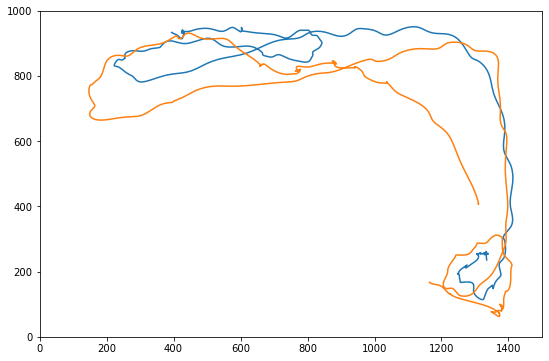

In [451]:
trial_original = all_data['Female1']
trial = trial_original
marker = 'BackCenter'
time = (15000,16000)
xlims = (0,1500)
ylims = (0,1000)
plt.figure(figsize=6*n.array([xlims[1]/ylims[1], 1]))


plt.plot(trial[marker+'_1_x'][time[0]:time[1]],trial[marker+'_1_y'][time[0]:time[1]])
plt.plot(trial[marker+'_2_x'][time[0]:time[1]],trial[marker+'_2_y'][time[0]:time[1]])

plt.xlim(xlims)
plt.ylim(ylims)

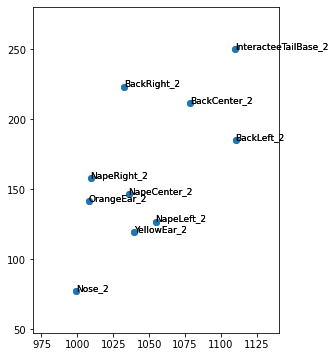

In [452]:

t = 20000
xs = []
ys = []
labs = []
for label in labels:
    mouse_idx = str(2)
    if label[-1] == mouse_idx:
        xs.append(trial[label+'_x'][t])
        ys.append(trial[label+'_y'][t])
        labs.append(label)

xlims = (n.nanmin(xs) - 30, n.nanmax(xs)+30)
ylims = (n.nanmin(ys) - 30, n.nanmax(ys)+30)
plt.figure(figsize=6*n.array([(xlims[1]-xlims[0])/(ylims[1]-ylims[0]), 1]))
        
        
plt.scatter(xs, ys)
for i in range(len(xs)):
    plt.text(xs[i], ys[i], labs[i],fontsize=9)
    
    
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()

### Calculate vectors

You can define a new vector in the dictionary `vectors`. The key is the name of the vector that is formed. The tuple contains two elements, the start point and end point of the vector. You can set the start or end point to be a tuple as well, in which case the average of the two vectors in the tuple will be taken (e.g. head_1 vector is from NapeCenter1 to the midpoint of green and red tape).

In [453]:
vectors = {'rear_1' : ('ImplantedTailBase_1', 'BackCenter_1'),
           'rear_2' : ('InteracteeTailBase_2', 'BackCenter_2'),
           'front_1': ('BackCenter_1', 'NapeCenter_1'),
           'front_2': ('BackCenter_2', 'NapeCenter_2'),
           'head_1' : ('NapeCenter_1', ('GreenTape_1', 'RedTape_1')),
           'head_2' : ('NapeCenter_2', ('YellowEar_2', 'OrangeEar_2')),
           'front_1_to_front_2' : ('NapeCenter_1', 'NapeCenter_2'),
           'front_2_to_front_1' : ('NapeCenter_2', 'NapeCenter_1'),
           'front_1_to_rear_2' : ('NapeCenter_1', 'InteracteeTailBase_2'),
           'front_2_to_rear_1' : ('NapeCenter_2', 'ImplantedTailBase_1'),
           'rear_1_to_rear_2' : ('BackCenter_1','BackCenter_2'),
           'rear_2_to_rear_1' : ('BackCenter_2','BackCenter_1')}

In [454]:
trial['rear_1']

ValueError: no field of name rear_1

In [455]:
names = []
datas = []
dtypes = []
for vec in vectors.keys():
    names.append(vec+'_ang')
    names.append(vec+'_vec_x')
    names.append(vec+'_vec_y')    
    names.append(vec+'_start_x')
    names.append(vec+'_start_y')
    dtypes += [n.float]*5
    datas += [n.zeros(trial.shape[0])]*5

In [456]:
%%time
trial = rfn.append_fields(trial_original, names, datas, dtypes)
trial = n.array(trial, trial.dtype)

CPU times: user 14.8 s, sys: 1.94 s, total: 16.7 s
Wall time: 19.5 s


In [457]:
for vec in vectors:
    start = vectors[vec][0]
    end = vectors[vec][1]
        
    if type(start) == tuple:
        start_xs = 0.5*(trial[start[0] + '_x'] + trial[start[1] + '_x'] )
        start_ys = 0.5*(trial[start[0] + '_y'] + trial[start[1] + '_y'] )
    else: 
        start_xs = trial[start + '_x']
        start_ys = trial[start + '_y']

    if type(end) == tuple:
        end_xs = 0.5*(trial[end[0] + '_x'] + trial[end[1] + '_x'] )
        end_ys = 0.5*(trial[end[0] + '_y'] + trial[end[1] + '_y'] )
    else:
        end_xs = trial[end + '_x']
        end_ys = trial[end + '_y']
    
    vector = n.stack((end_xs-start_xs, end_ys-start_ys),axis=1)
    angles = get_angle(vector, n.array([[1,0]]*vector.shape[0]))
    trial[vec+'_ang'] = angles
    trial[vec+'_vec_x'] = vector[:,0]
    trial[vec+'_vec_y'] = vector[:,1]
    trial[vec+'_start_x'] = start_xs
    trial[vec+'_start_y'] = start_ys

## Visualize vectors

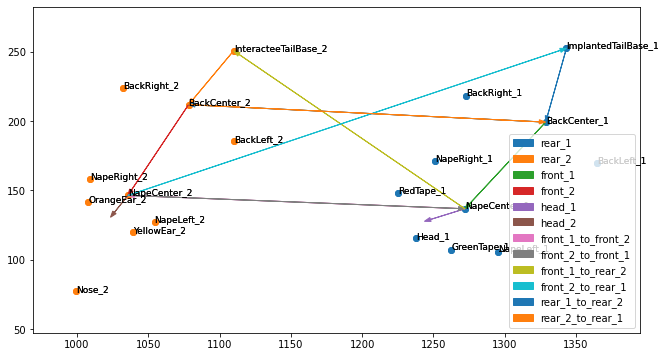

In [458]:

t = 20000
xs_1 = []
ys_1 = []
labs_1 = []
xs_2 = []
ys_2 = []
labs_2 = []
for label in labels:
    if label[-1] == str(1):
        xs_1.append(trial[label+'_x'][t])
        ys_1.append(trial[label+'_y'][t])
        labs_1.append(label)
    if label[-1] == str(2):
        xs_2.append(trial[label+'_x'][t])
        ys_2.append(trial[label+'_y'][t])
        labs_2.append(label)

xlims = (n.nanmin(n.concatenate((xs_1,xs_2))) - 30, n.nanmax(n.concatenate((xs_1,xs_2)))+30)
ylims = (n.nanmin(n.concatenate((ys_1,ys_2))) - 30, n.nanmax(n.concatenate((ys_1,ys_2)))+30)
plt.figure(figsize=6*n.array([(xlims[1]-xlims[0])/(ylims[1]-ylims[0]), 1]))
        
        
plt.scatter(xs_1, ys_1)
for i in range(len(xs_1)):
    plt.text(xs_1[i], ys_1[i], labs_1[i],fontsize=9)
plt.scatter(xs_2, ys_2)
for i in range(len(xs_2)):
    plt.text(xs_2[i], ys_2[i], labs_2[i],fontsize=9)
    

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
i = 0
for vec in vectors:
    plt.arrow(trial[vec+'_start_x'][t], trial[vec+'_start_y'][t], trial[vec+'_vec_x'][t], trial[vec+'_vec_y'][t], 
              width = 0.01,head_width=3, length_includes_head = True, label=vec, color=colors[i])
    i = (i + 1) % len(colors)
#     plt.plot([trial[vec+'_start_x'][t], trial[vec+'_start_x'][t]+trial[vec+'_vec_x'][t]], \
#              [trial[vec+'_start_y'][t], trial[vec+'_start_y'][t]+trial[vec+'_vec_y'][t]], label=vec)

plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()
    

In [459]:
for v in vectors:
    print("At time t, angle for " + v + " is: " + n.str((trial[v+'_ang'][t])))

At time t, angle for rear_1 is: 254.67365395085153
At time t, angle for rear_2 is: 230.8370301543411
At time t, angle for front_1 is: 227.7578957502923
At time t, angle for front_2 is: 236.9100533652069
At time t, angle for head_1 is: 197.69578884386712
At time t, angle for head_2 is: 232.26593759852958
At time t, angle for front_1_to_front_2 is: 177.6698569225146
At time t, angle for front_2_to_front_1 is: 357.6698569225146
At time t, angle for front_1_to_rear_2 is: 144.95977303957042
At time t, angle for front_2_to_rear_1 is: 18.998467934864607
At time t, angle for rear_1_to_rear_2 is: 177.13253617856512
At time t, angle for rear_2_to_rear_1 is: 357.1325361785651


In [417]:
def compare_angles(ang1, ang2, reduce=False):
    if reduce: diff = n.min([(ang1-ang2)%360, 360-((ang1-ang2)%360)], axis=0)
    else: diff = (ang1 - ang2) % 360
    return diff

In [418]:
def plot_rad_hist(diff,n_bins=50, bin_width=0.1, figsize=(8,8), title=None):
    f, ax = plt.subplots(figsize=figsize, subplot_kw = {'projection' : 'polar'})
    hist, bins = n.histogram(diff, bins=n_bins, range=(0,360))
    bins = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)] 
    ax.set_rgrids([])
    bars = ax.bar(n.deg2rad(bins), hist, width=bin_width)
    ax.set_title(title)
    return f, bins, hist

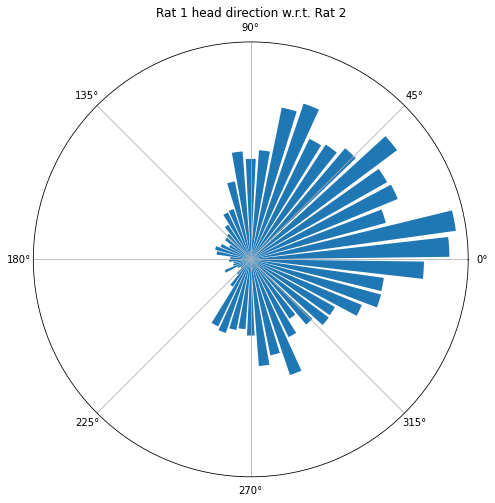

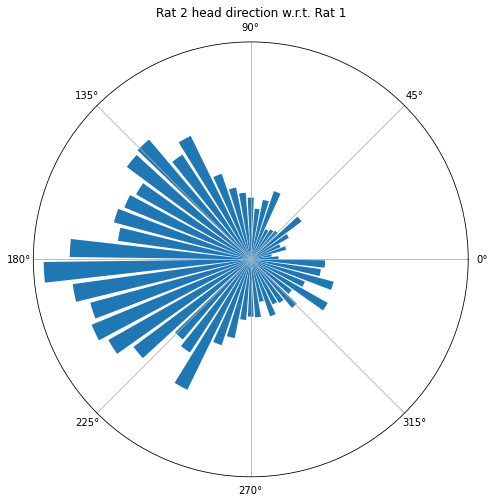

In [419]:
head_1_to_rat_2_diff = compare_angles(trial['head_1_ang'],trial['front_1_to_front_2_ang'])
head_2_to_rat_1_diff = compare_angles(trial['head_2_ang'], trial['front_2_to_front_1_ang'])

plot_rad_hist(head_1_to_rat_2_diff, title='Rat 1 head direction w.r.t. Rat 2');
plot_rad_hist(head_2_to_rat_1_diff, title='Rat 2 head direction w.r.t. Rat 1');

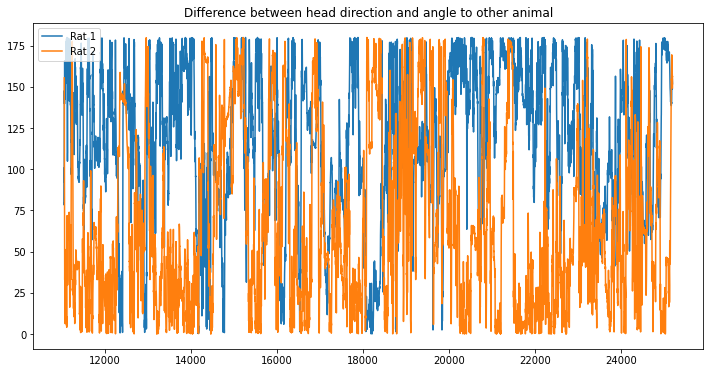

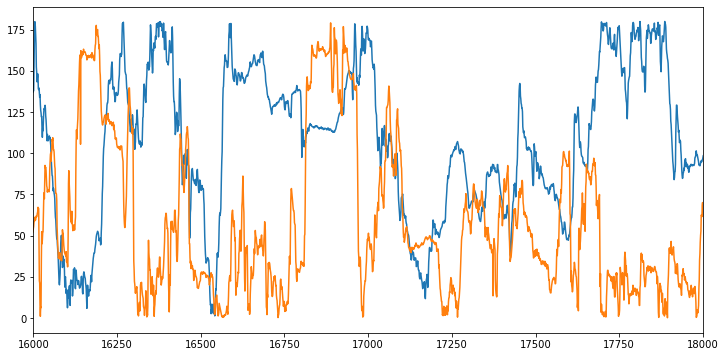

In [420]:
plt.figure(figsize=(12,6))
plt.plot(n.abs(180-head_1_to_rat_2_diff),label='Rat 1')
plt.plot(n.abs(180-head_2_to_rat_1_diff),label='Rat 2')
plt.title("Difference between head direction and angle to other animal")
plt.legend()
plt.show()
plt.figure(figsize=(12,6))
plt.xlim(16000,18000)
plt.plot(n.abs(180-head_1_to_rat_2_diff))
plt.plot(n.abs(180-head_2_to_rat_1_diff))
plt.show()

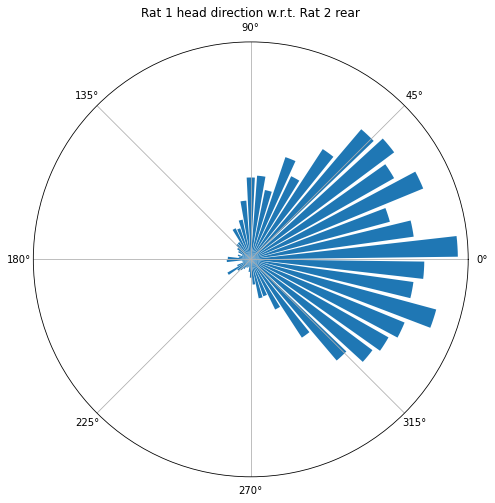

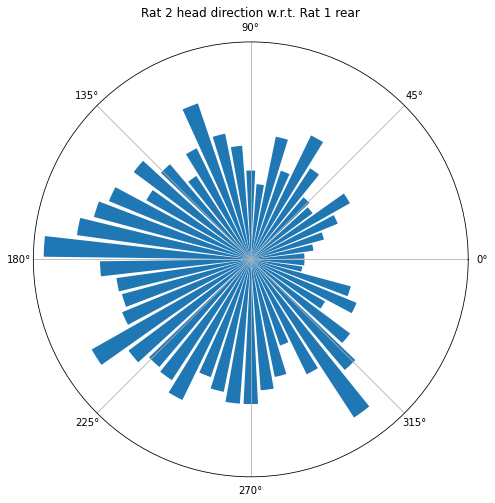

In [421]:
head_1_to_rat_2_rear_diff = compare_angles(trial['head_1_ang'],trial['front_1_to_rear_2_ang'])
head_2_to_rat_1_rear_diff = compare_angles(trial['head_2_ang'], trial['front_2_to_rear_1_ang'])

plot_rad_hist(head_1_to_rat_2_rear_diff, title='Rat 1 head direction w.r.t. Rat 2 rear');
plot_rad_hist(head_2_to_rat_1_rear_diff, title='Rat 2 head direction w.r.t. Rat 1 rear');

## Velocities

In [422]:
trial_with_vectors = trial

In [423]:
velocities_to_calculate = [
    'BackCenter_1',
    'BackCenter_2',
    'head_1_vec',
    'head_2_vec'
]

In [424]:
names = []; dtypes = []; datas = []
for label in velocities_to_calculate:
    names.append(label+'_vel_mag')
    names.append(label+'_vel_ang')
    names.append(label+'_vel_x')
    names.append(label+'_vel_y')    
    dtypes += [n.float]*4
    datas += [n.zeros(trial.shape[0])]*4

In [425]:
trial = rfn.append_fields(trial_with_vectors, names, datas, dtypes)
trial = n.array(trial, trial.dtype)

In [426]:
xy_vec.shape

(30270, 2)

In [427]:
velocities_to_calculate

['BackCenter_1', 'BackCenter_2', 'head_1_vec', 'head_2_vec']

In [428]:
for label in velocities_to_calculate:
    vel_x = n.gradient(trial[label+'_x'])
    vel_y = n.gradient(trial[label+'_y'])
    vel_mag = n.sqrt(vel_x**2 + vel_y**2)
    xy_vec = n.stack((vel_x, vel_y), axis=1)
    vel_ang = get_angle(xy_vec,n.array([[1,0]]*vector.shape[0]) )
    vel_label = label + '_vel'
    trial[vel_label + '_mag'] = vel_mag
    trial[vel_label + '_ang'] = vel_mag
    trial[vel_label + '_x'] = vel_x
    trial[vel_label + '_y'] = vel_y

(1000.0, 5000.0)

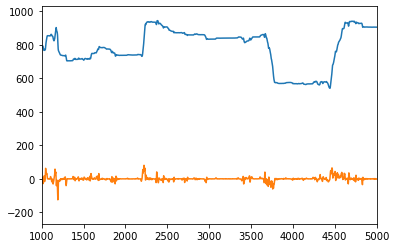

In [429]:
label = 'BackCenter_1'

plt.plot(trial[label+'_y'])
plt.plot(10*trial[label+'_vel_y'])
plt.xlim(1000,5000)

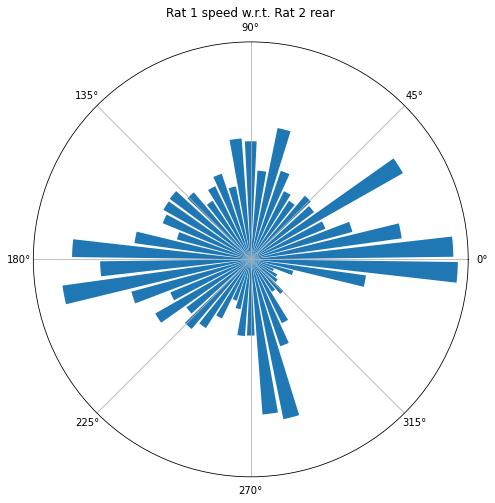

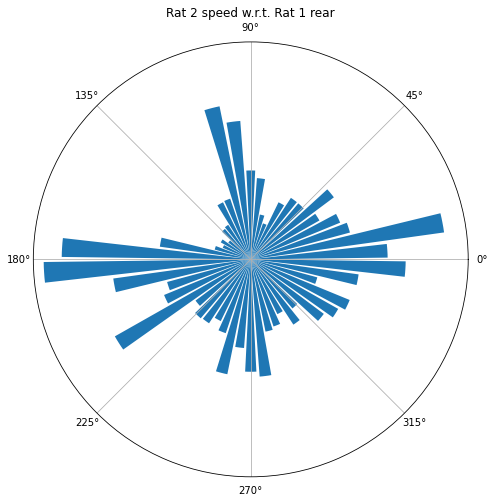

In [431]:
rat_1_to_rat_2_speed = compare_angles(trial['BackCenter_1_vel_ang'],trial['rear_1_to_rear_2_ang'])
rat_2_to_rat_1_speed = compare_angles(trial['BackCenter_2_vel_ang'],trial['rear_2_to_rear_1_ang'])



plot_rad_hist(rat_1_to_rat_2_speed, title='Rat 1 speed w.r.t. Rat 2 rear');
plot_rad_hist(rat_2_to_rat_1_speed, title='Rat 2 speed w.r.t. Rat 1 rear');

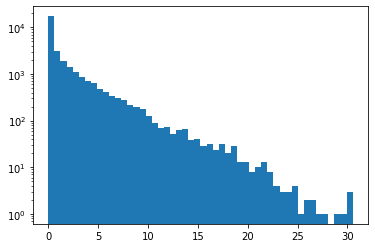

In [434]:
plt.hist(trial['BackCenter_1_vel_mag'], bins=50, log=True);

In [436]:
n.unique(trial['ann'])

array(['Approach', 'Following', 'broadly-Social', 'conspecific-contact',
       'head-to-head', 'head-to-tail', 'nan', 'no-contact'], dtype='<U30')